In [1]:
import numpy as np

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm
import seaborn as sns
import ipywidgets as widgets

# Below is for pretty printing
sm.init_printing(use_unicode=True) 

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & \begin{cases}
w h_2 & 
\text{if }l_2 = 1  \\
b & \text{if }l_2 = 0 
\end{cases} \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_{1}& = & \begin{cases}
w h_1 & 
\text{if }l_1 = 1  \\
b & \text{if }l_1 = 0 
\end{cases} \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

## Question 1
First the needed functions are defined below:

In [4]:
# Consumption function for both outcomes of l_t
def con(w,h,l,b):
    if l==1:
        con = w*h*l
    else:
        con = b
    return con
   
# Utility of consumption
def utility(con,rho):
    return (con**(1-rho))/(1-rho)

# Disutility of working
def disutility(gamma,l):
    return gamma*l

# Model in period 2
def v2(l2,b,rho,gamma,w,h2):
    return utility(con(w,h2,l2,b),rho) - disutility(gamma,l2)
    
# Model in period 1
def v1(l1,b,rho,gamma,w,h1,Delta,beta,v2_interp):
     
    # v2 with NO accumulation
    h2_NA = h1 + l1
    v2_NA = v2_interp([h2_NA])[0]
    
    # v2 if there is accumulation
    h2_A = h1 + l1 + Delta
    v2_A = v2_interp([h2_A])[0]
    
    # expected value of v2
    v2 = 0.5*v2_A + 0.5*v2_NA
    
    # Now we can return v1    
    return utility(con(w,h1,l1,b),rho) - disutility(gamma,l1) + beta*v2
    
    

#### **Question 1.1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital).

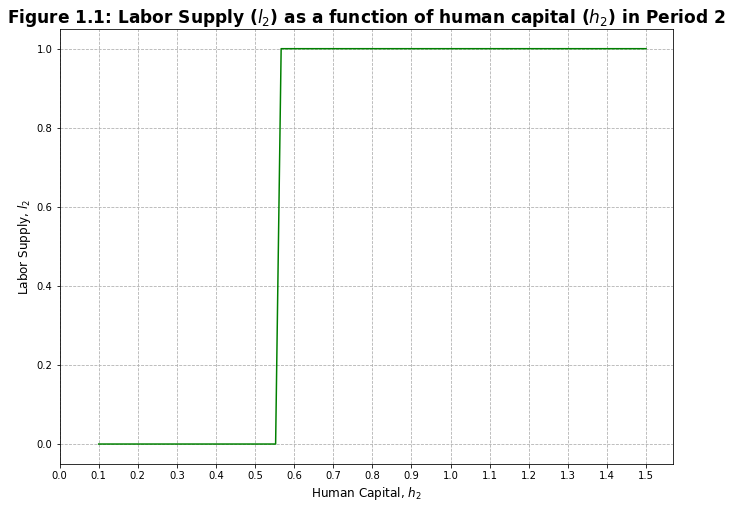

In [5]:
# A function to solve the model in period 2 is defined
def solve_p2(rho,gamma,w,b, Delta):
    
    # a. defining grids 
    v2_vec = np.empty(100)
    l2_vec = np.empty(100)
    
    # b. solve for h
    for i,h2 in enumerate(h_vec):
        # if the utility of working < not working => you do not work, l2=0
        if v2(0,b,rho,gamma,w,h2) > v2(1,b,rho,gamma,w,h2):
            l2_vec[i] = 0
        # if opposite is true => you work, l2=1
        else:
            l2_vec[i] = 1
            
        v2_vec[i] = v2(l2_vec[i],b,rho,gamma,w,h2)
        
    return l2_vec, v2_vec
    
# Use above function to get the solution for period 2
l2_vec, v2_vec = solve_p2(rho,gamma,w,b, Delta)

# Plotting labor supply as a function of human capital
fig1 = plt.figure(figsize=(11,8))
ax = fig1.add_subplot(1,1,1)
ax.plot(h_vec,l2_vec, color='green')

# Customizing plot
ax.set_xlabel('Human Capital, $h_2$', fontsize=12)
ax.set_ylabel('Labor Supply, $l_2$', fontsize=12)
ax.set_title('Figure 1.1: Labor Supply ($l_2$) as a function of human capital ($h_2$) in Period 2', fontsize=17, fontweight='bold')
ax.grid(linestyle='--', linewidth=.8)
plt.xticks(np.linspace(0,1.5,16))
plt.show()

Now we want to find the exact level of human capital where the worker chooses to work.

In [6]:
# Below we find the value when l2 goes from 0 to 1. It finds the index, which is then inserted in the h_vec to find the value
ind = np.nonzero(l2_vec == 1)[0][0]
change = h_vec[ind]

# Below is used to print text in bold
BOLD = '\033[1m'
END = '\033[0m'

print('Amount of human capital required for worker to choose working in period 2 is a level greater or equal to ' + BOLD + str(round(change,4)) + END + '.')

Amount of human capital required for worker to choose working in period 2 is a level greater or equal to 0.5667.


#### **Question 1.2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital)

The interpolated function, v2_interp, defines the expected utility of period 2, namely the term $E_1[v_2(h_2)]$.

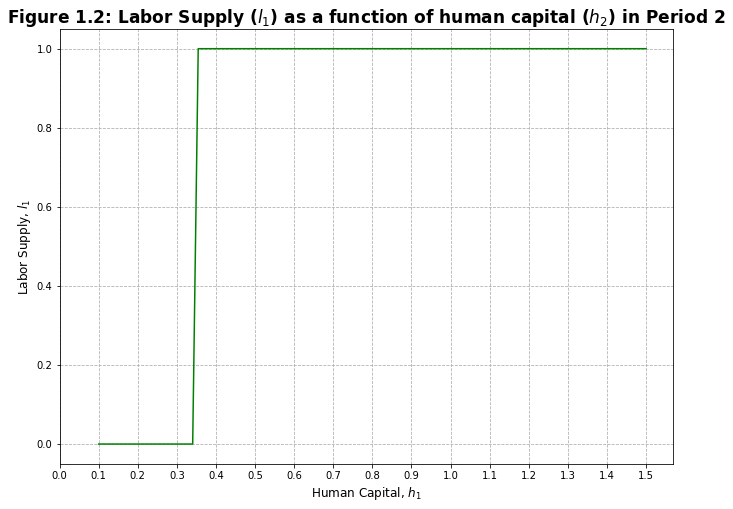

In [7]:
# a. interpolate utility from period 2
v2_interp = interpolate.RegularGridInterpolator([h_vec], v2_vec, bounds_error=False, fill_value=None)

# b. create functionto solve problem in period 1
def solve_p1(w, b, rho, gamma, Delta, beta, v2_interp):
    
    # i. define grids
    v1_vec = np.empty(100)
    l1_vec = np.empty(100, dtype=int)
    
    # ii. solve for each h in grid
    for i, h1 in enumerate(h_vec):
       
        # 1. compare v1 for l1 = 0 and l1 = 1 and return the l1 that maximizes v1
        if v1(0,b,rho,gamma,w,h1,Delta,beta,v2_interp) > v1(1,b,rho,gamma,w,h1,Delta,beta,v2_interp):
            l1_vec[i] = 0
        else:
            l1_vec[i] = 1
        
        # 2. append the v1 value from the optimized l1
        v1_vec[i] = v1(l1_vec[i],b,rho,gamma,w,h1,Delta,beta,v2_interp)
               
    return v1_vec, l1_vec

v1_vec, l1_vec = solve_p1(w, b, rho, gamma, Delta, beta, v2_interp)

# Plotting labor supply as a function of human capital
fig2 = plt.figure(figsize=(11,8))
ax = fig2.add_subplot(1,1,1)
ax.plot(h_vec,l1_vec, color='green')

# Customizing plot
ax.set_xlabel('Human Capital, $h_1$', fontsize=12)
ax.set_ylabel('Labor Supply, $l_1$', fontsize=12)
ax.set_title('Figure 1.2: Labor Supply ($l_1$) as a function of human capital ($h_2$) in Period 2', fontsize=17, fontweight='bold')
ax.grid(linestyle='--', linewidth=.8)
plt.xticks(np.linspace(0,1.5,16))
plt.show()

In [8]:
# Below we find the value when l2 goes from 0 to 1. It finds the index, which is then inserted in the h_vec to find the value
ind = np.nonzero(l1_vec == 1)[0][0]
change = h_vec[ind]

# Below is used to print text in bold
BOLD = '\033[1m'
END = '\033[0m'

print('Amount of human capital required for worker to choose working in period 1 is a level greater or equal to ' + BOLD + str(round(change,4)) + END + '.')

Amount of human capital required for worker to choose working in period 1 is a level greater or equal to 0.3545.


#### **Question 1.3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not. 

To explore whether our worker will work at a wage level lower than the unemployment benefit, $b$, we need to explore our workers utility at different wage levels. For this purpose a vector of different wages ranging from zero to the unemployment benefit of 1.

In [12]:
# Wage vector
w_vec = np.linspace(0.1,1,100)
# loop over forskellige lønniveauer, find nytte uden job og sammenlign hvorvidt nytten er højere ved en løn lavere end 1


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [ ]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

#### **Question 2.1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

First all the relevant symbols and functions are defined below:

In [ ]:
# Defining all symbols
alpha = sm.symbols('alpha')
h = sm.symbols('h')
b = sm.symbols('b')
phi = sm.symbols('phi')
gamma = sm.symbols('gamma')

v = sm.symbols('v_t')
s = sm.symbols('s_t')
s_lag = sm.symbols('s_{t-1}')
pi = sm.symbols('pi_t')
pi_lag = sm.symbols('pi_t-1')
y = sm.symbols('y_t')
y_lag = sm.symbols('y_{t-1}')

# Functions
AD = sm.Eq(pi,(1/(h*alpha)*(v-(1+b*alpha)*y)))
display(AD)

SRAS = sm.Eq(pi,pi_lag + gamma*y - phi*gamma*y_lag + s - phi*s_lag )
display(SRAS)

Now we make a function that set the above equations equal to each other:

In [ ]:
# AD = SRAS
ADSRAS = sm.Eq((1/(h*alpha)*(v-(1+b*alpha)*y)),pi_lag + gamma*y - phi*gamma*y_lag + s - phi*s_lag)
print('The equations are set equal to each other which becomes:')
print()
display(ADSRAS)

In [ ]:
# Solve for y
y_EQ = sm.solve(ADSRAS,y)
print('The solution for y is:')
print()
display(y_EQ)

Now we can substitute this value into the SRAS function to get the expression for $\pi_t$:

In [ ]:
SRAS_new = SRAS.subs(y,y_EQ[0])
pi_EQ = sm.solve(SRAS_new,pi)
print('The solution for pi is:')
print()
display(pi_EQ)

#### **Question 2.2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

We want to be able to parameterize the equations and for this we use sympy's lambdify function:

In [ ]:
# Lambdify functions
lambd_y = sm.lambdify((alpha,h,b,phi,gamma,pi_lag,y_lag,s_lag,v,s),y_EQ)
lambd_pi = sm.lambdify((alpha,h,b,phi,gamma,pi_lag,y_lag,s_lag,v,s),pi_EQ)

# Now we can find the equilibrium values
y_par0 = lambd_y(par['alpha'],par['h'],par['b'],par['phi'],par['gamma'],0,0,0,0,0)
pi_par0 = lambd_pi(par['alpha'],par['h'],par['b'],par['phi'],par['gamma'],0,0,0,0,0)

print('The equilibrium values of y and pi when parameters are equal to zero are:')
print(y_par0,pi_par0)

In [ ]:
y_parv = lambd_y(par['alpha'],par['h'],par['b'],par['phi'],par['gamma'],0,0,0,0.1,0)
pi_parv = lambd_pi(par['alpha'],par['h'],par['b'],par['phi'],par['gamma'],0,0,0,0.1,0)

print('The equilibrium values of y and pi when v = 0.1 and all other parameters are zero are:')
print(y_parv,pi_parv)

Below the different equilibriums are illustrated

In [ ]:
# First we define the AD and SRAS functions
def AD_fig(v,y):
    return (1/(par['h']*par['alpha'])*(v-(1+par['b']*par['alpha'])*y))
def SRAS_fig(pi_lag,y,y_lag,s,s_lag):
    return pi_lag + par['gamma']*y - par['phi']*par['gamma']*y_lag + s - par['phi']*s_lag

In [ ]:
# Below the needed values for the figure are defined
y = np.linspace(-0.1,0.1,50)

# Values without shock
y_lag = 0
pi_lag = 0
v = 0
s = 0
s_lag = 0

# Only value that changes with shock is v
v_s = 0.1

AD = AD_fig(v,y)
AD_shock = AD_fig(v_s,y)
SRAS = SRAS_fig(pi_lag,y,y_lag,s,s_lag)

# Figure is plotted
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(1,1,1)
ax.plot(y,AD, label='AD, $v_t=0$')
ax.plot(y,AD_shock,label='AD, $v_t=0.1$')
ax.plot(y,SRAS, label='SRAS')
ax.set_xlabel('$y_t$',size=12)
ax.set_ylabel('$\pi_t$',size=12)
ax.legend()
ax.grid()
plt.title('Figure 2.1: Equilibrium with and without shock', size=18)
plt.show()


**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [ ]:
par['delta'] = 0.80
par['omega'] = 0.15

#### **Question 2.3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [ ]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

#### **Question 2.4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

#### **Question 2.5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

#### **Quesiton 2.6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [ ]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

#### **Question 1:** Plot the histograms of the budget shares for each good across agents.

Here we have Cobb-Douglas preferences which means that the budget shares are represented by the $\beta$'s. These are plotted in the below diagram.

In [ ]:
# betas
b1 = betas[:,0]
b2 = betas[:,1]
b3 = betas[:,2]

# Plotting the histograms of each good
hist, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20,6), sharey=True, sharex=True)
ax1.hist(b1, bins=15)
ax1.set_title('Good 1', size=13, fontweight='bold')
ax2.hist(b2, color='r', bins=15)
ax2.set_title('Good 2', size=13, fontweight='bold')
ax3.hist(b3, color='g', bins=15)
ax3.set_title('Good 3', size=13, fontweight='bold')
hist.suptitle('Figure 3.1: Budget Shares across Agents', size=20)
ax1.set_ylabel('Number of consumers', size=13)
ax2.set_xlabel('Budget share of goods', size=13)




From the figure above we see that the highest budget share is that of Good 1, while Good 3 has the smallest budget share. From the 

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

#### **Question 2:** Plot the excess demand functions.

First the functions given are defined

In [ ]:
# 1. Demand functions of goods, p3=1
def dem1(p1,p2,e1,e2,e3,b1):
    I = p1*e1 + p2*e2 + e3
    return b1*(I/p1)

def dem2(p1,p2,e1,e2,e3,b2):
    I = p1*e1 + p2*e2 + e3
    return b2*(I/p2)

def dem3(p1,p2,e1,e2,e3,b3):
    I = p1*e1 + p2*e2 + e3
    return b3*I

# 2. Excess demand functions
def ex_dem1(p1,p2,e1,e2,e3):
    return np.sum(dem1(p1,p2,e1,e2,e3,b1) - e1)

def ex_dem2(p1,p2,e1,e2,e3):
    return np.sum(dem2(p1,p2,e1,e2,e3,b2) - e2)

def ex_dem3(p1,p2,e1,e2,e3):
    return np.sum(dem3(p1,p2,e1,e2,e3,b3) - e3)

In [ ]:
# A set of price vectors are defined
p1_vec = np.linspace(0.1,5,100)
p2_vec = np.linspace(0.1,5,100)
p3_vec = 1

# Now grids for the endowments and prices are constructed
e1_grid = np.empty((100,100))
e2_grid = np.empty((100,100))
e3_grid = np.empty((100,100))
p1_grid, p2_grid = np.meshgrid(p1_vec,p2_vec)

# Now we can find the excess demands with a loop
for i,p1 in enumerate(p1_vec):
    for j,p2 in enumerate(p2_vec):
        e1_grid[i,j] = ex_dem1(p1,p2,e1,e2,e3)
        e2_grid[i,j] = ex_dem2(p1,p2,e1,e2,e3)
        e3_grid[i,j] = ex_dem3(p1,p2,e1,e2,e3)

Now we can make the plots of the excess demand functions

In [ ]:
fig = plt.figure(figsize=(10,19))

ax1 = fig.add_subplot(3,1,1,projection='3d')
fig1 = ax1.plot_surface(p1_grid, p2_grid, e1_grid, color='green', cmap='rainbow')
ax1.set_xlabel('$p_1$')
ax1.set_ylabel('$p_2$')
ax1.invert_xaxis()
ax1.set_title('Excess demand of Good 1', fontweight='bold')
fig.colorbar(fig1, shrink=0.5, aspect=5)

ax2 = fig.add_subplot(3,1,2,projection='3d')
fig2 = ax2.plot_surface(p1_grid, p2_grid, e2_grid, color='blue', cmap='rainbow')
ax2.set_xlabel('$p_1$')
ax2.set_ylabel('$p_2$')
ax2.invert_xaxis()
ax2.set_title('Excess demand of Good 2', fontweight='bold')
fig.colorbar(fig2, shrink=0.5, aspect=5)

ax3 = fig.add_subplot(3,1,3,projection='3d')
fig3 = ax3.plot_surface(p1_grid, p2_grid, e3_grid, color='red', cmap='rainbow')
ax3.set_xlabel('$p_1$')
ax3.set_ylabel('$p_2$')
ax3.invert_xaxis()
ax3.set_title('Excess demand of Good 3', fontweight='bold')
fig.colorbar(fig3, shrink=0.5, aspect=5)

The above figures show that the excess demand of the goods increase when the price is decreasing.

#### **Question 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

To find the Walras equilibrium prices $(p_1,p_2)$ where the excess demands are approximately zero the tâtonnement process described above is used.

In [ ]:
# 1. First we set the tolerance and adjustment aggressivity parameter and make initial guesses on the prices
kappa = 0.5 
eps = 1e-8
p1 = 2
p2 = 1.2
maxi = 2500 # maximum iterations

def wal_eq(betas,p1,p2,e1,e2,e3,eps,kappa,maxi):
    t=0
    while True:
    # 2. Calculate excess demands of good 1 and 2
        z1 = ex_dem1(p1,p2,e1,e2,e3)
        z2 = ex_dem2(p1,p2,e1,e2,e3)
    
    # 3. Defining whether to stop
        if np.abs(z1) < eps and np.abs(z2) < eps or t >= maxi:
            print(f'{t:3d}: p1 = {p1:12.6f} --> excess demand good 1 --> {z1:14.6f}')
            print(f'{t:3d}: p2 = {p2:12.6f} --> excess demand good 2 --> {z2:14.6f}')
            break
               
    # 4. Updating prices and returning to step 2   
        p1 = p1 + kappa*(z1/N)
        p2 = p2 + kappa*(z2/N)
        
        if t < 2 or t%150 == 0:
            print(f'{t:3d}: p1 = {p1:12.6f} --> excess demand good 1 --> {z1:14.6f}')
            print(f'{t:3d}: p2 = {p2:12.6f} --> excess demand good 2 --> {z2:14.6f}')
        elif t == 2:
            print('   ...')
                    
        t += 1
    return p1,p2
    
p1,p2 = wal_eq(betas,p1,p2,e1,e2,e3,eps,kappa,maxi)

The Walras equilirium prices for good 1 and good 2 are:  
$\quad \pmb{p_1 = 6.49} $  
$\quad \pmb{p_2 = 2.62}$

#### **Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.  
First we define the utility function below,

In [ ]:
# Utility function
def util_eq(p1,p2,e1,e2,e3,gamma,betas):     
    return ((dem1(p1,p2,e1,e2,e3,b1)**b1)*(dem2(p1,p2,e1,e2,e3,b2)**b2)*(dem3(p1,p2,e1,e2,e3,b3)**b3))**gamma

util = util_eq(p1,p2,e1,e2,e3,gamma,betas)    

# Mean and variance of Walras-Equilibrium
print(f'The mean of the Walras-Equilibrium is {round(np.mean(util),2)}')
print(f'The variance of the Walras-Equilibrium is {round(np.var(util),2)}')

In [ ]:
# A histogram is used to plot the distribution
hist, ax = plt.subplots(figsize=(10,6))
ax.hist(util, bins=250, color='g', alpha=.5)
ax.set_title('Figure 3.3: Distribution of Utility in the Walras Equilibrium', size=20)
ax.set_xlabel('Utility', size=14)
ax.set_ylabel('Consumers', size=14)
plt.show()

#### **Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?  
To make equally distributed endowments we make a new random draw and set the endowments equal to each other. Hereafter, the prices are calculated again as in question 4 and the mean and variance values are found.

In [ ]:
# We make a new draw of e
e = np.random.exponential(zeta,size=N)
e = e1 = e2 = e3

# Now we repeat the function in 3.3 to find the Walras-Equilibrium with endowmens that are equally distributed
p1,p2 = wal_eq(betas,p1,p2,e1,e2,e3,eps,kappa,maxi)

The Walras equilirium prices for good 1 and good 2 with equally distributed endowments are:  
$\quad \pmb{p_1 = 6.42} $  
$\quad\pmb{p_2 = 2.59}$  
Thus, both are a little lower compared to the prices in question 3.3 where the endowments are not equally distributed.  
Now the two utility distributions are plotted in a histogram to be compared.

In [ ]:
# Function for new utilities
def util_eq(p1,p2,e1,e2,e3,gamma,betas):     
    return ((dem1(p1,p2,e1,e2,e3,b1)**b1)*(dem2(p1,p2,e1,e2,e3,b2)**b2)*(dem3(p1,p2,e1,e2,e3,b3)**b3))**gamma

# Getting utilities
util_e = util_eq(p1,p2,e1,e2,e3,gamma,betas)

# Mean and variance of Walras-Equilibrium
print(f'The mean of the Walras-Equilibrium with equally distributed endowments is {round(np.mean(util_e),2)}')
print(f'The variance of the Walras-Equilibrium with equally distributed endowments is {round(np.var(util_e),2)}')

Thus, the mean is now slightly lower while the variance is twice as high with equally distributed endowments.

In [ ]:
# Plotting histograms in same figure to compare distributions
hist, ax = plt.subplots(figsize=(10,7))
ax.hist(util_e, bins=250, color='g', alpha=.5, label='Equal Distribution')
ax.hist(util,bins=250,color='b',alpha=.5, label= 'Unequal Distribution')
ax.set_title('Figure 3.4: Distribution Comparison of Utilities in the Walras Equilibrium', size=20)
ax.set_xlabel('Utility', size=14)
ax.set_ylabel('Consumers', size=14)
plt.legend(loc='lower right',edgecolor='black')
plt.show()

From the above figure it is seen that having equally distributed endowments draw the distribution towards 0. 

To see how gamma influences the distribution of the utilities, an interactive graph where the gamma value can be changed is made.

In [ ]:
# Utility function to make figure
def util_sl(p1,p2,e1,e2,e3,gamma,betas):
    util_sl = ((dem1(p1,p2,e1,e2,e3,b1)**b1)*(dem2(p1,p2,e1,e2,e3,b2)**b2)*(dem3(p1,p2,e1,e2,e3,b3)**b3))**gamma
    return util_sl

# Making interactive figure with slider for gamma values
def interactive_figure(p1,p2,e1,e2,e3,gamma,betas):
    
    # a. calculations
    dist = util_sl(p1,p2,e1,e2,e3,gamma,betas)
    
    # b. figure
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1,1,1)
    ax.hist(dist,bins=250, color='g',alpha=.5)
    ax.set_title('Figure 3.5: Distribution with different values of $\gamma$', size=20)
    ax.set_xlabel('Utility', size=14)
    ax.set_ylabel('Consumers', size=14)
    
widgets.interact(interactive_figure,
    p1=widgets.fixed(p1),
    p2=widgets.fixed(p2),
    e1=widgets.fixed(e1),
    e2=widgets.fixed(e2),
    e3=widgets.fixed(e3),
    gamma=widgets.FloatSlider(description="$\gamma$", min=0.01, max=2, step=0.01, value=.8),
    betas=widgets.fixed(betas)
);
    

In the above figure it is shown that the gamma value has a big impact on how the utilities in the Walras Equilibrium are distributed. This is no surprise as gamma influences the budget shares in the Cobb-Douglas utility function given. A higher gamma will draw the distribution of utilites towards zero while a small gamma will draw the distribution towards a higher utility.